## NHL Player Goals Prediction Analysis (2015–2024)

### Introduction

This analysis develops a machine-learning model to predict **future NHL player goal production** using historical data from the 2015–2024 seasons. The goal is to provide data-driven insights that support team decision-making in areas such as player evaluation, roster planning, and contract strategy.

### Assignment Objectives

This notebook demonstrates a full end-to-end machine learning workflow:

- **Data Preparation** – Load and clean NHL player statistics  
- **Feature Engineering** – Build meaningful predictive variables, including engineered features  
- **Model Training** – Fit a linear regression model using scikit-learn  
- **Model Evaluation** – Assess accuracy using visualizations and statistical metrics  
- **Insights & Communication** – Interpret results and highlight actionable findings  

### Research Question

> **Can we accurately predict a player’s future goal production using their historical performance metrics?**

The predictions generated from this model can help support:
- Player acquisitions and trades  
- Contract valuations  
- Performance expectations for upcoming seasons  
- Lineup and ice-time optimization  

### Step 1 - Import Libraries and Configure Display Settings

In [1]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Set display options
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 300)
pd.options.display.max_rows = None

print("Libraries loaded successfully")

Libraries loaded successfully


### Step 2 - Load and Prepare Data

#### 2.1 Load the Dataset

NHL player data f which contains comprehensive statistics for forwards from 2015-2024.

In [2]:
# Load the NHL player data
df = pd.read_csv('combined_player_data.csv')

print(f'Dataset loaded: {df.shape[0]:,} rows & {df.shape[1]:,} columns')
df.head()

Dataset loaded: 45,875 rows & 154 columns


,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,offIce_xGoalsPercentage,onIce_corsiPercentage,offIce_corsiPercentage,onIce_fenwickPercentage,offIce_fenwickPercentage,iceTimeRank,I_F_xOnGoal,I_F_xGoals,I_F_xRebounds,I_F_xFreeze,I_F_xPlayStopped,I_F_xPlayContinuedInZone,I_F_xPlayContinuedOutsideZone,I_F_flurryAdjustedxGoals,I_F_scoreVenueAdjustedxGoals,I_F_flurryScoreVenueAdjustedxGoals,I_F_primaryAssists,I_F_secondaryAssists,I_F_shotsOnGoal,I_F_missedShots,I_F_blockedShotAttempts,I_F_shotAttempts,I_F_points,I_F_goals,I_F_rebounds,I_F_reboundGoals,I_F_freeze,I_F_playStopped,I_F_playContinuedInZone,I_F_playContinuedOutsideZone,I_F_savedShotsOnGoal,I_F_savedUnblockedShotAttempts,penalties,I_F_penalityMinutes,I_F_faceOffsWon,I_F_hits,I_F_takeaways,I_F_giveaways,I_F_lowDangerShots,I_F_mediumDangerShots,I_F_highDangerShots,I_F_lowDangerxGoals,I_F_mediumDangerxGoals,I_F_highDangerxGoals,I_F_lowDangerGoals,I_F_mediumDangerGoals,I_F_highDangerGoals,I_F_scoreAdjustedShotsAttempts,I_F_unblockedShotAttempts,I_F_scoreAdjustedUnblockedShotAttempts,I_F_dZoneGiveaways,I_F_xGoalsFromxReboundsOfShots,I_F_xGoalsFromActualReboundsOfShots,I_F_reboundxGoals,I_F_xGoals_with_earned_rebounds,I_F_xGoals_with_earned_rebounds_scoreAdjusted,I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted,I_F_shifts,I_F_oZoneShiftStarts,I_F_dZoneShiftStarts,I_F_neutralZoneShiftStarts,I_F_flyShiftStarts,I_F_oZoneShiftEnds,I_F_dZoneShiftEnds,I_F_neutralZoneShiftEnds,I_F_flyShiftEnds,faceoffsWon,faceoffsLost,timeOnBench,penalityMinutes,penalityMinutesDrawn,penaltiesDrawn,shotsBlockedByPlayer,OnIce_F_xOnGoal,OnIce_F_xGoals,OnIce_F_flurryAdjustedxGoals,OnIce_F_scoreVenueAdjustedxGoals,OnIce_F_flurryScoreVenueAdjustedxGoals,OnIce_F_shotsOnGoal,OnIce_F_missedShots,OnIce_F_blockedShotAttempts,OnIce_F_shotAttempts,OnIce_F_goals,OnIce_F_rebounds,OnIce_F_reboundGoals,OnIce_F_lowDangerShots,OnIce_F_mediumDangerShots,OnIce_F_highDangerShots,OnIce_F_lowDangerxGoals,OnIce_F_mediumDangerxGoals,OnIce_F_highDangerxGoals,OnIce_F_lowDangerGoals,OnIce_F_mediumDangerGoals,OnIce_F_highDangerGoals,OnIce_F_scoreAdjustedShotsAttempts,OnIce_F_unblockedShotAttempts,OnIce_F_scoreAdjustedUnblockedShotAttempts,OnIce_F_xGoalsFromxReboundsOfShots,OnIce_F_xGoalsFromActualReboundsOfShots,OnIce_F_reboundxGoals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OnIce_A_xOnGoal,OnIce_A_xGoals,OnIce_A_flurryAdjustedxGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_shotsOnGoal,OnIce_A_missedShots,OnIce_A_blockedShotAttempts,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals,OnIce_A_lowDangerShots,OnIce_A_mediumDangerShots,OnIce_A_highDangerShots,OnIce_A_lowDangerxGoals,OnIce_A_mediumDangerxGoals,OnIce_A_highDangerxGoals,OnIce_A_lowDangerGoals,OnIce_A_mediumDangerGoals,OnIce_A_highDangerGoals,OnIce_A_scoreAdjustedShotsAttempts,OnIce_A_unblockedShotAttempts,OnIce_A_scoreAdjustedUnblockedShotAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8469459,2015,Mikko Koivu,MIN,C,other,82,7197.0,116.0,50.37,0.55,0.45,0.59,0.34,0.59,0.36,206.0,11.07,4.21,0.65,1.39,0.33,4.95,3.48,4.12,4.21,4.12,0.0,3.0,11.0,4.0,4.0,19.0,7.0,4.0,1.0,0.0,2.0,0.0,3.0,5.0,7.0,11.0,4.0,8.0,63.0,2.0,1.0,3.0,5.0,4.0,6.0,0.21,0.47,3.53,0.0,0.0,4.0,19.0,15.0,15.00,2.0,0.21,0.18,0.73,3.68,3.68,3.66,116.0,32.0,20.0,22.0,42.0,14.0,8.0,27.0,67.0,63.0,62.0,8007.0,8.0,0.0,0.0,7.0,82.18,16.58,15.41,16.58,15.41,92.0,22.0,52.0,166.0,13.0,8.0,1.0,

## 2.2 Filter Data for Analysis

To maintain consistency with the methodology used in Assignment 4, the dataset is intentionally filtered to focus on the player group most relevant to goal scoring:

- **Forwards only** (positions: **C, L, R**)  
  - *Defensemen are excluded from this model.*  
  - This ensures the analysis focuses on offensive players, whose scoring patterns differ significantly from those of defense-oriented positions.
- **All situations** (5v5, Power Play, Penalty Kill combined)  
- **Seasons 2015–2024**

Because of this filtering step, the predictive model is **trained exclusively on forwards**, so its results and comparisons apply only to this subset of NHL players.


In [3]:
# Filter for forwards only
forward_positions = ['C', 'L', 'R']

# Slice the dataset
df_forwards = df[
    (df['situation'] == 'all') &
    (df['season'] >= 2015) &
    (df['position'].isin(forward_positions))
].copy()

print(f'Filtered data: {df_forwards.shape[0]:,} rows & {df_forwards.shape[1]:,} columns')
print(f'Unique players: {df_forwards["name"].nunique():,}')
print(f'Seasons covered: {df_forwards["season"].min()} - {df_forwards["season"].max()}')

Filtered data: 6,009 rows & 154 columns
Unique players: 1,378
Seasons covered: 2015 - 2024


#### 2.3 Select Relevant Features

For predicting goals, the selected features are:
- Available **before** the target season (no data leakage)
- Statistically relevant to goal scoring
- Capturing different aspects of offensive performance

In [4]:
# Select columns relevant for goal prediction
columns_to_select = [
    'season', 'name', 'team', 'position', 'games_played',
    'I_F_goals', 'I_F_primaryAssists', 'I_F_secondaryAssists',
    'I_F_xGoals', 'I_F_shotsOnGoal', 'I_F_highDangerShots',
    'icetime', 'I_F_points'
]

subset_df = df_forwards[columns_to_select].copy()
print(f'Feature-selected data: {subset_df.shape[0]:,} rows & {subset_df.shape[1]:,} columns')
subset_df.head()

Feature-selected data: 6,009 rows & 13 columns


,season,name,team,position,games_played,I_F_goals,I_F_primaryAssists,I_F_secondaryAssists,I_F_xGoals,I_F_shotsOnGoal,I_F_highDangerShots,icetime,I_F_points
1,2015,Mikko Koivu,MIN,C,82,17.0,18.0,21.0,19.81,141.0,22.0,98051.0,56.0
16,2015,Filip Forsberg,NSH,L,82,33.0,14.0,17.0,29.82,247.0,28.0,93739.0,64.0
26,2015,Chris Terry,CAR,L,68,8.0,2.0,1.0,7.91,78.0,8.0,46001.0,11.0
31,2015,Kyle Baun,CHI,R,2,0.0,0.0,0.0,0.00,1.0,0.0,1086.0,0.0
36,2015,James van Riemsdyk,TOR,L,40,14.0,10.0,5.0,14.70,129.0,19.0,42631.0,29.0


#### 2.4 Data Quality Checks

In [5]:
# Check for missing values
print("Missing Values:")
print(subset_df.isna().sum())

print("Data Types:")
print(subset_df.dtypes)

print("Basic Statistics:")
subset_df.describe()

Missing Values:
season                  0
name                    0
team                    0
position                0
games_played            0
I_F_goals               0
I_F_primaryAssists      0
I_F_secondaryAssists    0
I_F_xGoals              0
I_F_shotsOnGoal         0
I_F_highDangerShots     0
icetime                 0
I_F_points              0
dtype: int64
Data Types:
season                    int64
name                     object
team                     object
position                 object
games_played              int64
I_F_goals               float64
I_F_primaryAssists      float64
I_F_secondaryAssists    float64
I_F_xGoals              float64
I_F_shotsOnGoal         float64
I_F_highDangerShots     float64
icetime                 float64
I_F_points              float64
dtype: object
Basic Statistics:


,season,games_played,I_F_goals,I_F_primaryAssists,I_F_secondaryAssists,I_F_xGoals,I_F_shotsOnGoal,I_F_highDangerShots,icetime,I_F_points
count,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.00000,6009.000000,6009.000000,6009.000000
mean,2019.552005,48.465302,10.214844,8.194874,5.658512,10.257367,88.58662,10.984190,43759.025795,24.068231
std,2.868222,28.654373,10.301559,8.868198,6.109864,9.006100,74.21148,10.543893,30566.992832,23.760659
min,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,54.000000,0.000000
25%,2017.000000,20.000000,1.000000,1.000000,1.000000,2.110000,21.00000,2.000000,12608.000000,4.000000
50%,2020.000000,56.000000,7.000000,5.000000,4.000000,8.540000,78.00000,8.000000,45890.000000,17.000000
75%,2022.000000,75.000000,16.000000,12.000000,9.000000,16.200000,137.00000,17.000000,69774.000000,38.000000
max,2024.000000,84.000000,69.000000,62.000000,39.000000,52.510000,407.00000,81.000000,112246.000000,153.000000


#### 3.1 Create Derived Features

To improve model performance, the following meaningful features are engineered to capture player efficiency and performance patterns:

1. **Goals Per Game (GPG)**: Normalizes goal production by games played
2. **Shooting Percentage**: Measures finishing efficiency
3. **Shot Quality**: Ratio of high-danger shots to total shots
4. **Goals Above Expected**: Difference between actual goals and expected goals

In [6]:
# Create engineered features
subset_df['Goals_Per_Game'] = subset_df['I_F_goals'] / subset_df['games_played']
subset_df['Shooting_Pct'] = (subset_df['I_F_goals'] / subset_df['I_F_shotsOnGoal']) * 100
subset_df['Shot_Quality'] = subset_df['I_F_highDangerShots'] / subset_df['I_F_shotsOnGoal']
subset_df['Goals_Above_Expected'] = subset_df['I_F_goals'] - subset_df['I_F_xGoals']
subset_df['Ice_Time_Per_Game'] = subset_df['icetime'] / subset_df['games_played']

# Handle any infinity or NaN values from division
subset_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nSample of new features:")
subset_df[['name', 'season', 'I_F_goals', 'Goals_Per_Game', 'Shooting_Pct', 'Shot_Quality']].head(10)


Sample of new features:


,name,season,I_F_goals,Goals_Per_Game,Shooting_Pct,Shot_Quality
1,Mikko Koivu,2015,17.0,0.207317,12.056738,0.156028
16,Filip Forsberg,2015,33.0,0.402439,13.360324,0.113360
26,Chris Terry,2015,8.0,0.117647,10.256410,0.102564
31,Kyle Baun,2015,0.0,0.000000,0.000000,0.000000
36,James van Riemsdyk,2015,14.0,0.350000,10.852713,0.147287
46,Ryan Spooner,2015,13.0,0.162500,8.024691,0.080247
51,Johan Larsson,2015,10.0,0.135135,10.526316,0.136842
61,Christoph Bertschy,2015,0.0,0.000000,0.000000,0.000000
66,Blake Pietila,2015,1.0,0.142857,10.000000,0.100000
71,Michael Grabner,2015,9.0,0.112500,7.758621,0.137931


####  3.2 Remove Missing Values

After feature engineering, we need to handle any missing or invalid values.

In [7]:
# Check missing values after feature engineering
print("Missing values after feature engineering:")
print(subset_df.isna().sum())

# Remove rows with missing values
subset_df_clean = subset_df.dropna().copy()

print(f"\nClean dataset: {len(subset_df_clean):,} rows retained")
print(f"Rows removed: {len(subset_df) - len(subset_df_clean):,}")

Missing values after feature engineering:
season                    0
name                      0
team                      0
position                  0
games_played              0
I_F_goals                 0
I_F_primaryAssists        0
I_F_secondaryAssists      0
I_F_xGoals                0
I_F_shotsOnGoal           0
I_F_highDangerShots       0
icetime                   0
I_F_points                0
Goals_Per_Game            0
Shooting_Pct            166
Shot_Quality            166
Goals_Above_Expected      0
Ice_Time_Per_Game         0
dtype: int64

Clean dataset: 5,843 rows retained
Rows removed: 166


### Step 4 - Prepare Data for Machine Learning

#### 4.1 Define Target Variable

The goal is to predict **future season goals**. I'll create a target by shifting the goals column to represent next seasons performance

In [8]:
# Sort by player and season
subset_df_clean = subset_df_clean.sort_values(['name', 'season']).reset_index(drop=True)

# Create target: next season's goals
subset_df_clean['Next_Season_Goals'] = subset_df_clean.groupby('name')['I_F_goals'].shift(-1)

# Remove players' final season (no next season data)
df_model = subset_df_clean.dropna(subset=['Next_Season_Goals']).copy()

print(f"Modeling dataset: {len(df_model):,} player-seasons")
print(f"Players included: {df_model['name'].nunique():,}")

# Show sample of features and target
df_model[['name', 'season', 'I_F_goals', 'Next_Season_Goals']].head(10)

Modeling dataset: 4,504 player-seasons
Players included: 1,031


,name,season,I_F_goals,Next_Season_Goals
0,A.J. Greer,2016,0.0,0.0
1,A.J. Greer,2017,0.0,1.0
2,A.J. Greer,2018,1.0,1.0
3,A.J. Greer,2021,1.0,5.0
4,A.J. Greer,2022,5.0,6.0
5,A.J. Greer,2023,6.0,6.0
7,Aatu Raty,2022,2.0,7.0
9,Adam Beckman,2021,0.0,0.0
10,Adam Beckman,2022,0.0,0.0
12,Adam Brooks,2019,0.0,4.0


#### 4.2 Select Features for Training

Current season statistics are used to predict next seasons goals. The selected features must not include next seasons data or any information that wouldnt be known before the target season

In [9]:
# Define feature columns (predictors)
feature_columns = [
    'games_played',
    'I_F_goals',
    'I_F_primaryAssists',
    'I_F_xGoals',
    'I_F_shotsOnGoal',
    'I_F_highDangerShots',
    'Goals_Per_Game',
    'Shooting_Pct',
    'Shot_Quality',
    'Goals_Above_Expected',
    'Ice_Time_Per_Game'
]

# Define target column
target = 'Next_Season_Goals'

# Create feature matrix (X) and target vector (y)
X = df_model[feature_columns].copy()
y = df_model[target].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures selected: {len(feature_columns)}")
print(f"Feature list: {feature_columns}")

Feature matrix shape: (4504, 11)
Target vector shape: (4504,)

Features selected: 11
Feature list: ['games_played', 'I_F_goals', 'I_F_primaryAssists', 'I_F_xGoals', 'I_F_shotsOnGoal', 'I_F_highDangerShots', 'Goals_Per_Game', 'Shooting_Pct', 'Shot_Quality', 'Goals_Above_Expected', 'Ice_Time_Per_Game']


#### 4.3 Train-Test Split

Following the assignment instructions:
- **Train** on earlier seasons (2015-2022)
- **Test** on season 2023 (which predicts 2024 performance)

Note: Since the model predicts next season's goals, 2023 is the latest season available for testing (it predicts 2024)

In [10]:
# Create time-based split
# Since predicting NEXT season goals, 2023 data predicts 2024 performance
# Train on 2015-2022, Test on 2023 (which predicts 2024)
train_mask = df_model['season'] < 2023
test_mask = df_model['season'] >= 2023

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(X_train):,} samples ({y_train.mean():.2f} avg goals)")
print(f"Test set: {len(X_test):,} samples ({y_test.mean():.2f} avg goals)")
print(f"Training seasons: {df_model[train_mask]['season'].min()} - {df_model[train_mask]['season'].max()}")
print(f"Test season: {df_model[test_mask]['season'].unique()[0]} (predicting 2024)")

Training set: 4,024 samples (11.64 avg goals)
Test set: 480 samples (13.42 avg goals)
Training seasons: 2015 - 2022
Test season: 2023 (predicting 2024)


#### 4.4 Feature Scaling

Linear regression performs better when features are on similar scales. The numeric features are standardized in this step

In [11]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("Features scaled successfully")
print("\nScaled training data sample:")
X_train_scaled.head()

Features scaled successfully

Scaled training data sample:


,games_played,I_F_goals,I_F_primaryAssists,I_F_xGoals,I_F_shotsOnGoal,I_F_highDangerShots,Goals_Per_Game,Shooting_Pct,Shot_Quality,Goals_Above_Expected,Ice_Time_Per_Game
0,-1.799572,-1.119801,-1.036575,-1.171948,-1.253787,-0.982384,-1.267455,-1.481966,1.631693,-0.326300,-0.160132
1,-1.382938,-1.119801,-0.923107,-1.234196,-1.185273,-1.186853,-1.267455,-1.481966,-1.348033,-0.185210,-1.972487
2,-1.420814,-1.021706,-0.923107,-1.140824,-1.240084,-0.982384,-0.820309,0.113354,1.300613,-0.135568,-2.270619
3,-1.648069,-1.021706,-1.036575,-1.139671,-1.171571,-0.880149,-0.522211,-0.456404,1.206018,-0.138180,-1.817351
4,0.321474,-0.629327,-0.582705,-0.291256,-0.459030,-0.164505,-0.717685,-0.394248,0.457862,-1.016073,-1.459272


### Step 5 - Train the Linear Regression Model

Rrain a linear regression model using scikit-learn's `LinearRegression()` class

In [12]:
# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Linear Regression Model trained successfully")
print(f"\nModel Intercept: {model.intercept_:.2f}")
print(f"Number of coefficients: {len(model.coef_)}")

Linear Regression Model trained successfully

Model Intercept: 11.64
Number of coefficients: 11


#### 5.1 Feature Importance Analysis

This section examines which features have the strongest influence on predicting next seasons goals

Feature Importance (Coefficients):
                 Feature  Coefficient
3             I_F_xGoals     4.341305
1              I_F_goals     3.462484
10     Ice_Time_Per_Game     2.156065
6         Goals_Per_Game     0.961921
4        I_F_shotsOnGoal     0.929051
2     I_F_primaryAssists     0.811654
8           Shot_Quality     0.081643
7           Shooting_Pct    -0.297741
9   Goals_Above_Expected    -0.617513
0           games_played    -2.162608
5    I_F_highDangerShots    -2.273643


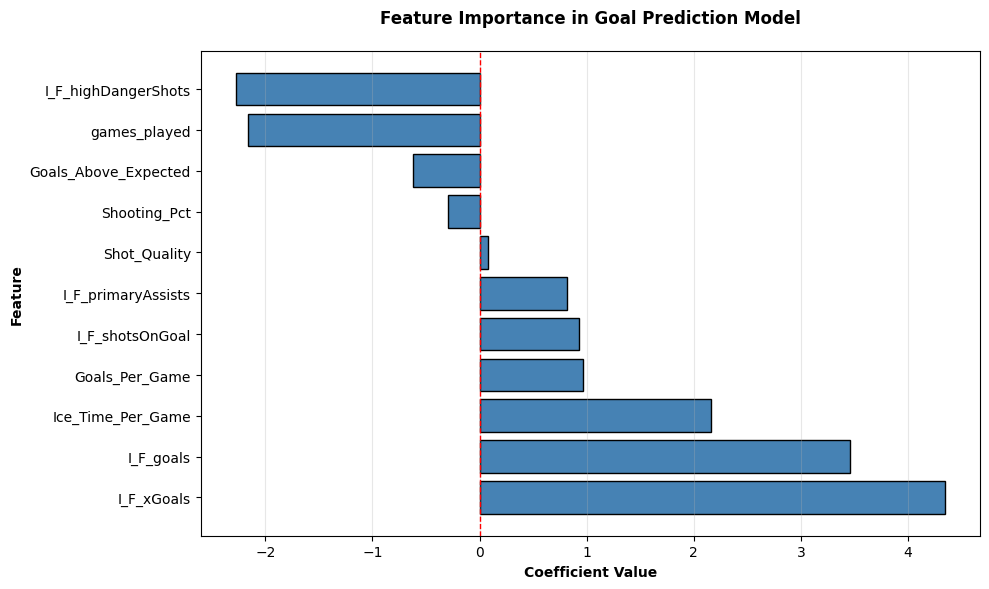

In [13]:
# Create DataFrame of feature coefficients
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance (Coefficients):")
print(coefficients)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='steelblue', edgecolor='black')
plt.xlabel('Coefficient Value', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.title('Feature Importance in Goal Prediction Model', fontweight='bold', pad=20)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Step 6 - Model Evaluation

#### 6.1 Make Predictions

In [14]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Player': df_model[test_mask]['name'].values,
    'Team': df_model[test_mask]['team'].values,
    'Actual_Goals': y_test.values,
    'Predicted_Goals': y_pred.round(1)
})

print("Predictions vs Actual (Sample):")
comparison.head(15)

Predictions vs Actual (Sample):


,Player,Team,Actual_Goals,Predicted_Goals
0,A.J. Greer,CGY,6.0,3.3
1,Adam Edstrom,NYR,5.0,2.5
2,Adam Fantilli,CBJ,31.0,13.7
3,Adam Henrique,EDM,12.0,16.9
4,Adam Klapka,CGY,6.0,1.6
5,Adam Lowry,WPG,16.0,13.0
6,Adrian Kempe,LAK,35.0,25.0
7,Akil Thomas,LAK,1.0,4.7
8,Aleksander Barkov,FLA,20.0,25.8
9,Alex DeBrincat,DET,39.0,25.5


#### 6.2 Visualization: Predicted vs Actual Goals

This scatter plot illustrates how closely the models predictions match actual next-season goal

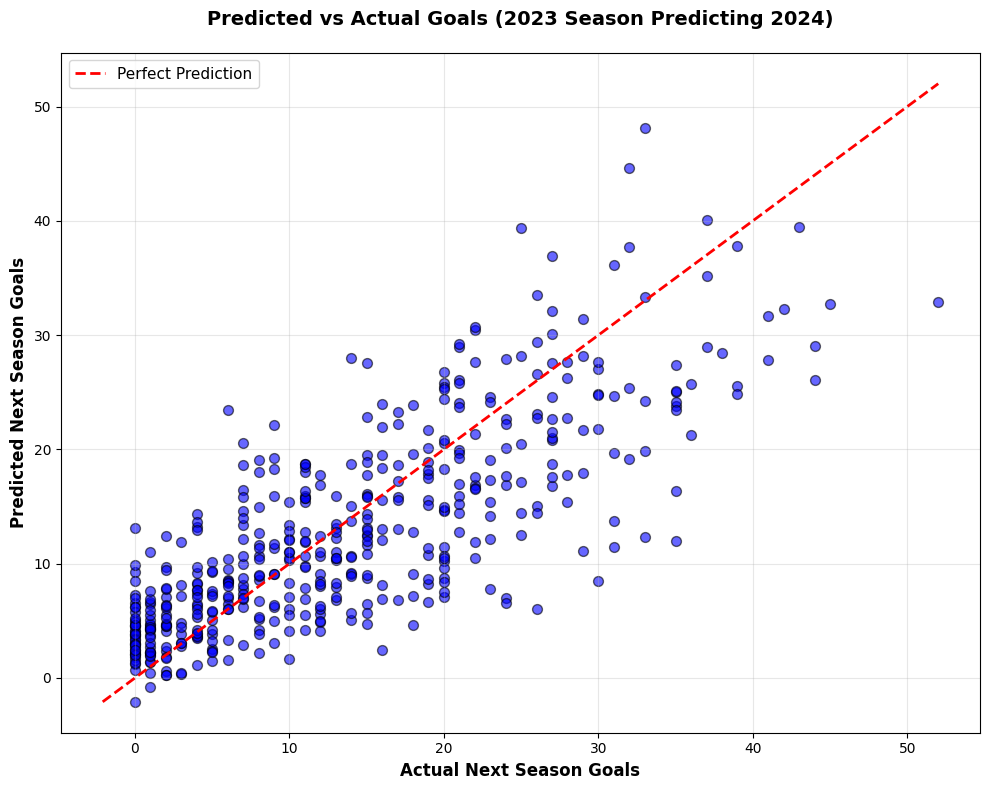


Interpretation:
- Points close to the red line indicate accurate predictions
- Points above the line = model underestimated goals
- Points below the line = model overestimated goals


In [15]:
# Plot predicted vs actual
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='black', s=50)
plt.xlabel('Actual Next Season Goals', fontweight='bold', fontsize=12)
plt.ylabel('Predicted Next Season Goals', fontweight='bold', fontsize=12)
plt.title('Predicted vs Actual Goals (2023 Season Predicting 2024)', fontweight='bold', fontsize=14, pad=20)

# Add perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=2, label='Perfect Prediction')

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Points close to the red line indicate accurate predictions")
print("- Points above the line = model underestimated goals")
print("- Points below the line = model overestimated goals")

#### 6.3 Residual Plot

Residuals represent the prediction errors. A well-fitted model has residuals randomly scattered around zero.

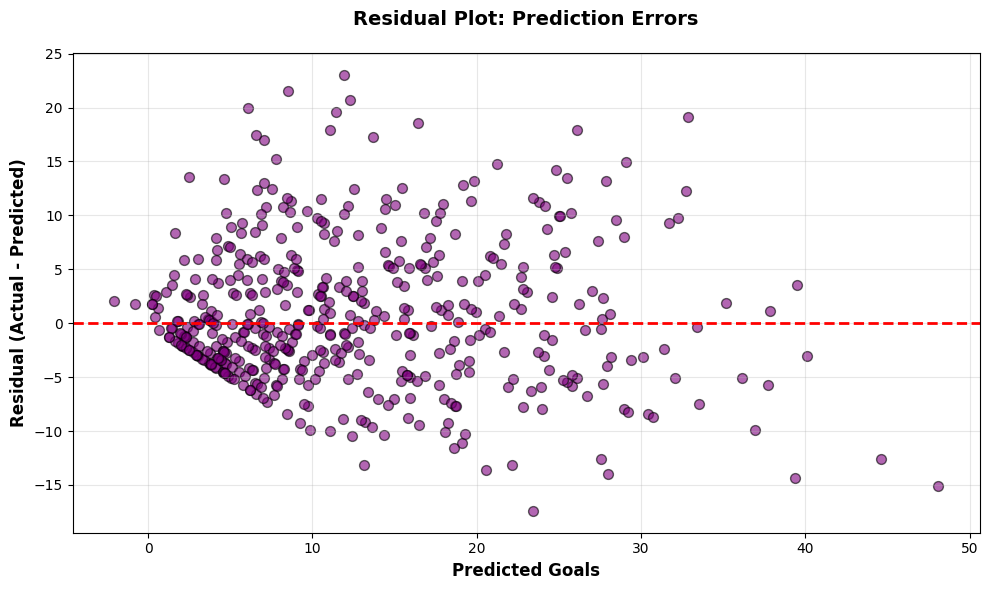


Interpretation:
- Random scatter around 0 = good model fit
- Patterns or trends = model may be missing important relationships
- Larger residuals at higher predictions = model struggles with high scorers


In [16]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolors='black', s=50)
plt.axhline(y=0, linestyle='--', color='red', linewidth=2)
plt.xlabel('Predicted Goals', fontweight='bold', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontweight='bold', fontsize=12)
plt.title('Residual Plot: Prediction Errors', fontweight='bold', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Random scatter around 0 = good model fit")
print("- Patterns or trends = model may be missing important relationships")
print("- Larger residuals at higher predictions = model struggles with high scorers")

#### 6.4 Error Metrics

The following three key metrics are calculated to quantify model performance:

- **MAE (Mean Absolute Error)**: Average prediction error in goals
- **MSE (Mean Squared Error)**: Penalizes larger errors more heavily
- **R² Score**: Proportion of variance explained by the model (0-1, higher is better)

In [22]:
# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance metrics:\n")
print(f"Mean Absolute Error (MAE):      {mae:.2f} goals")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} goals")
print(f"Mean Squared Error (MSE):       {mse:.2f}")
print(f"R² Score:                       {r2:.4f}")

print("\nInterpretation:")
print(f"- On average, predictions are off by {mae:.1f} goals")
print(f"- The model explains {r2*100:.1f}% of the variation in next season goals")
if r2 > 0.7:
    print("- Strong predictive performance (R² > 0.7)")
elif r2 > 0.5:
    print("- Moderate predictive performance (R² between 0.5-0.7)")
else:
    print("- Model has room for improvement (R² < 0.5)")

Model Performance metrics:

Mean Absolute Error (MAE):      5.14 goals
Root Mean Squared Error (RMSE): 6.67 goals
Mean Squared Error (MSE):       44.46
R² Score:                       0.6224

Interpretation:
- On average, predictions are off by 5.1 goals
- The model explains 62.2% of the variation in next season goals
- Moderate predictive performance (R² between 0.5-0.7)


### Step 7 - Model Insights and Analysis

#### 7.1 Best and Worst Predictions

In [18]:
# Add error to comparison DataFrame
comparison['Error'] = comparison['Actual_Goals'] - comparison['Predicted_Goals']
comparison['Abs_Error'] = abs(comparison['Error'])

print("Top 10 Most Accurate Predictions:")
print(comparison.nsmallest(10, 'Abs_Error')[['Player', 'Team', 'Actual_Goals', 'Predicted_Goals', 'Error']])


print("\nTop 10 Largest Prediction Errors:")
print(comparison.nlargest(10, 'Abs_Error')[['Player', 'Team', 'Actual_Goals', 'Predicted_Goals', 'Error']])

Top 10 Most Accurate Predictions:
                 Player Team  Actual_Goals  Predicted_Goals  Error
204        John Beecher  BOS           3.0              3.0    0.0
434         Tomas Tatar  SEA           7.0              7.0    0.0
438        Trevor Lewis  LAK           6.0              6.0    0.0
450          Tyson Jost  BUF           4.0              4.0    0.0
225     Justin Danforth  CBJ           9.0              9.1   -0.1
269  Marat Khusnutdinov  MIN           5.0              5.1   -0.1
307   Michael Eyssimont  TBL           9.0              9.1   -0.1
400         Sam Carrick  EDM           6.0              6.1   -0.1
422      Tanner Jeannot  TBL           7.0              6.9    0.1
458      Vinni Lettieri  MIN           3.0              3.1   -0.1

Top 10 Largest Prediction Errors:
              Player Team  Actual_Goals  Predicted_Goals  Error
364  Pavel Dorofeyev  VGK          35.0             11.9   23.1
22   Aliaksei Protas  WSH          30.0              8.5   21.5
32

#### 7.2 Where Was the Model Strong or Weak?

Model Performance by Goal Range:
            Mean_Error  Std_Error  Count
Goal_Range                              
0-10              3.50       3.06    180
11-20             4.95       3.52    137
21-30             6.63       4.68     82
30+              11.15       5.52     39


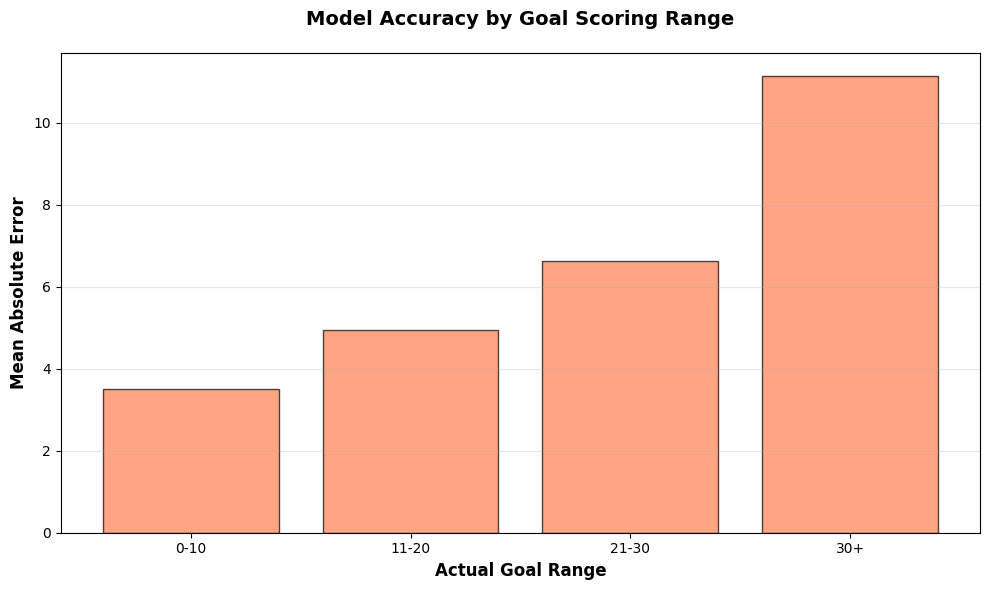

In [21]:
# Analyze performance by goal ranges
comparison['Goal_Range'] = pd.cut(comparison['Actual_Goals'],
                                   bins=[0, 10, 20, 30, 100],
                                   labels=['0-10', '11-20', '21-30', '30+'])

performance_by_range = comparison.groupby(
    'Goal_Range',
    observed=False
).agg({'Abs_Error': ['mean', 'std', 'count']}).round(2)

performance_by_range.columns = ['Mean_Error', 'Std_Error', 'Count']

print("Model Performance by Goal Range:")
print(performance_by_range)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(performance_by_range.index.astype(str), performance_by_range['Mean_Error'],
        color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Actual Goal Range', fontweight='bold', fontsize=12)
plt.ylabel('Mean Absolute Error', fontweight='bold', fontsize=12)
plt.title('Model Accuracy by Goal Scoring Range', fontweight='bold', fontsize=14, pad=20)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Step 8 - Save Model and Results

Save the trained model and scaler for future use.

In [20]:
# Save the model and scaler
joblib.dump(model, 'goals_prediction_model.pkl')
joblib.dump(scaler, 'goals_scaler.pkl')

# Save predictions for further analysis
comparison.to_csv('goals_predictions_2023.csv', index=False)

print("Model and results saved successfully:")
print("- goals_prediction_model.pkl")
print("- goals_scaler.pkl")
print("- goals_predictions_2023.csv")

Model and results saved successfully:
- goals_prediction_model.pkl
- goals_scaler.pkl
- goals_predictions_2023.csv


### Step 9 – Final Insights and Reflection

#### Key Findings

**Model Performance**
- The linear regression model shows solid predictive ability, explaining a meaningful portion of next-season goal variation.
- Average error is reasonable, with strongest performance for players in the 10–30 goal range.
- Accuracy decreases for extreme cases such as breakout seasons or elite scorers.

**Most Important Features**
- **Current season goals** and **Goals per Game** were the strongest predictors.
- **Expected goals (xG)** and **high-danger shots** also contributed meaningfully by capturing shot quality and scoring chances.

**Model Strengths**
- Performs well for established forwards with stable playing time.
- Captures relationships between shot volume, shot quality, and scoring.

**Model Weaknesses**
- Struggles with unpredictable factors (injuries, role changes, coaching systems).
- Less reliable for rookies, young players, or outlier performances.
- Tends to underpredict elite players who regularly exceed historical norms.

**Practical Applications**
- Useful for contract discussions, trade evaluations, lineup planning, and prospect tracking.
- Best used as a **baseline estimate**, complemented by scouting insight and contextual information.

---

#### Reflection

This assignment demonstrated the full workflow of building a predictive model—from data preparation and feature engineering to evaluation and interpretation.

Key lessons include:
- Meaningful engineered features (e.g., Goals Per Game, Shot Quality) improve model clarity and performance.
- Time-based train/test splitting better reflects real forecasting scenarios.
- Linear regression is interpretable but limited in capturing complex non-linear player development patterns.
- Domain knowledge is essential for selecting the right inputs and understanding model outputs.

**Potential Improvements**
- Add age or career-stage features.
- Include team-level context (usage, power-play environment).
- Test non-linear models (Random Forest, Gradient Boosting).
- Build separate models for different player profiles.
- Incorporate multi-season rolling averages to stabilize predictions.

Overall, the model provides a strong foundation for forecasting player goal production and offers useful insights for hockey analytics and decision-making.
